# Initialization

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from result_saver import SaverProvider

provider = SaverProvider()

# Generate Extreme Data

In [3]:
from soft_info import RepCodeIQSimulator

DEVICE = 'ibm_sherbrooke'
DISTANCE = 7
ROUNDS = 7
OTHER_DATE = '2021-11-11'
_RESETS = False
LOGICAL = 0 # NOT NEEDED FOR EXTREME IQ BCS HARDCODED 0

_is_hex = True
if DEVICE == 'ibmq_mumbai':
    _is_hex = False

# Initialize simulator
simulator = RepCodeIQSimulator(provider, DISTANCE, ROUNDS, DEVICE, _is_hex=_is_hex, _resets = _RESETS, other_date=OTHER_DATE)

In [ ]:
# Get noise model
p1Q = 0
pZ = 0
pRE = 0
pXY = 0

p2Q = 1e-2
# pRO = 15e-2
pRO = 0

multiplicator = 10e-2
p1Q = 5e-2 * multiplicator
p2Q = 5e-2 * multiplicator
pXY = 5e-2 * multiplicator
pZ = 5e-2 * multiplicator
pRO = 8e-5 * multiplicator # slightly lower than device median because no soft flips
pRE = 5e-3 * multiplicator

p1Q = multiplicator
p2Q = multiplicator
pXY = multiplicator
pZ = multiplicator
# pRO = multiplicator
# pRE = multiplicator

noise_model = simulator.get_noise_model(p1Q, p2Q, pXY, pZ, pRO, pRE)

In [ ]:
SHOTS = int(1e4)
P_AMBIG = 0.3

extreme_IQ_data = simulator.generate_extreme_IQ(SHOTS, P_AMBIG, noise_model=noise_model)
print(extreme_IQ_data.shape)

11:09:29 Warning: Getting counts via stim. This may take time.... IN FILE: /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/src/soft_info/IQ_data/simulator.py, LINE: 51


100%|██████████| 9502/9502 [00:03<00:00, 3056.25it/s]

(10000, 49)


# Get counts from IQ data

In [ ]:
import cpp_soft_info

print(cpp_soft_info.get_counts(extreme_IQ_data, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict, ROUNDS))

{'0000000 000000 000000 000010 000010 110011 000101 000000': 1, '0000000 000000 000000 000010 000011 111011 000000 011000': 1, '0000000 000000 000000 000101 101101 000000 001010 110101': 1, '0000000 000000 000000 001011 001000 001110 000110 000011': 1, '0000000 000000 000000 010001 010010 010000 010001 010101': 1, '0000000 000000 000000 010011 010000 011001 001100 000010': 1, '0000000 000000 000000 011000 100000 001001 000001 000000': 1, '0000000 000000 000000 100100 000100 001100 000010 001101': 1, '0000000 000000 000000 101101 100000 101100 000000 101110': 1, '0000000 000000 000001 000101 000100 010100 111100 000000': 1, '0000000 000000 000001 100001 001000 100110 000101 010000': 1, '0000000 000000 000001 100101 000111 100101 100011 001100': 1, '0000000 000000 000001 110001 100000 100100 000001 100101': 1, '0000000 000000 000010 000100 110010 100001 100000 100011': 1, '0000000 000000 000010 010001 000001 110000 001010 011100': 1, '0000000 000000 000010 010001 110100 010100 011000 000

# Decode IQ data

In [ ]:
import pymatching
import stim


circuit = stim.Circuit.generated("repetition_code:memory",
                                distance=DISTANCE,
                                rounds=ROUNDS,
                                after_clifford_depolarization=p2Q, #two-qubit-fidelity,
                                after_reset_flip_probability=pRE, #reset error,
                                before_measure_flip_probability=pRO, #measurement error,
                                before_round_data_depolarization=(pXY+pZ)/2) #idle error)
# print(circuit)

model = circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

P_DATA = 1e-2
P_MIXED = 1e-2
P_MEAS = P_AMBIG

In [ ]:
cpp_soft_info.soft_reweight_pymatching(matching._matching_graph, extreme_IQ_data[0], ROUNDS, _RESETS, simulator.qubit_mapping,
                                       simulator.grid_dict, simulator.processed_scaler_dict, -1, -1, -1,
                                        _adv_probs=True, _bimodal=False, merge_strategy="replace")

In [ ]:
import cpp_soft_info

matching = pymatching.Matching.from_detector_error_model(model)
# cpp_soft_info.reweight_edges_based_on_error_probs(matching._matching_graph, counts, False, "spitz")

result = cpp_soft_info.decode_IQ_shots(matching._matching_graph, extreme_IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                           common_measure=-1, _adv_probs=True, _bimodal=False, merge_strategy = "replace", _detailed=True)
print("num_errors:", result.num_errors, "out of", len(extreme_IQ_data), "shots")

: 

In [ ]:
matching = pymatching.Matching.from_detector_error_model(model)
result_flat = cpp_soft_info.decode_IQ_shots_flat(matching._matching_graph, extreme_IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, _detailed=True)
print("num_errors:", result_flat.num_errors, "out of", len(extreme_IQ_data), "shots")


num_errors: 2801 out of 10000 shots


In [ ]:
matching = pymatching.Matching.from_detector_error_model(model)

p_meas = P_MEAS + pRO
p_meas = -1
# p_meas = 45e-2

result_informed = cpp_soft_info.decode_IQ_shots_flat_informed(matching._matching_graph, extreme_IQ_data, 
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict,
                                           p_data = -1, p_mixed = -1, p_meas = p_meas, common_measure=-1, _detailed=True)

print("num_errors:", result_informed.num_errors, "out of", len(extreme_IQ_data), "shots")
         
# takes 1s

num_errors: 4201 out of 10000 shots


# Plot the results

In [ ]:
print("\nIQ:", result.indices, "\nFlat:", result_flat.indices, "\nInformed", result_informed.indices)


IQ: [0, 1, 2, 3, 5, 9, 11, 12, 15, 19, 20, 22, 24, 26, 35, 40, 43, 44, 45, 47, 51, 54, 56, 62, 63, 74, 75, 83, 85, 87, 91, 92, 95, 102, 103, 105, 106, 109, 112, 113, 115, 120, 126, 132, 133, 146, 147, 148, 151, 157, 159, 166, 171, 172, 173, 181, 183, 184, 191, 197, 198, 199, 201, 203, 209, 212, 214, 224, 233, 239, 241, 248, 250, 253, 259, 260, 266, 267, 271, 274, 277, 278, 290, 296, 306, 311, 314, 315, 316, 318, 319, 324, 331, 336, 337, 346, 348, 352, 360, 364, 367, 370, 371, 372, 386, 389, 391, 393, 401, 405, 407, 413, 421, 424, 426, 430, 431, 437, 438, 446, 448, 449, 452, 453, 456, 457, 460, 464, 470, 472, 474, 487, 490, 492, 502, 503, 511, 517, 518, 525, 532, 535, 537, 541, 543, 548, 550, 551, 554, 558, 570, 576, 580, 581, 584, 586, 588, 593, 595, 601, 603, 604, 606, 607, 608, 609, 611, 616, 619, 626, 628, 632, 633, 635, 640, 641, 644, 645, 649, 654, 662, 664, 668, 669, 671, 672, 673, 676, 679, 683, 686, 690, 693, 697, 701, 704, 708, 709, 725, 727, 734, 738, 741, 756, 757, 763, 768

-----IQ-----


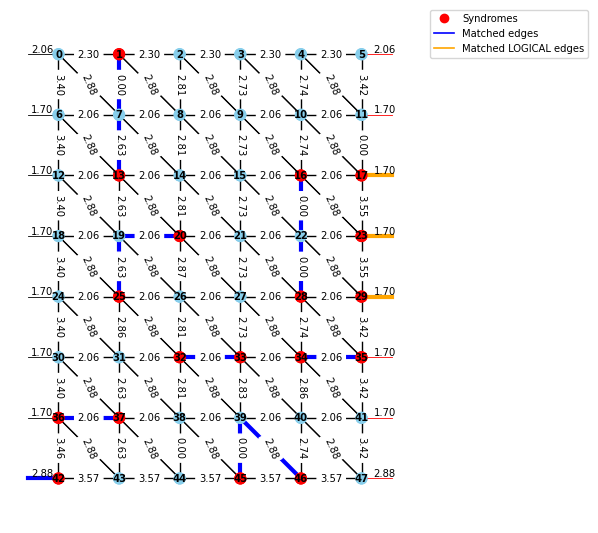

-----flat-----


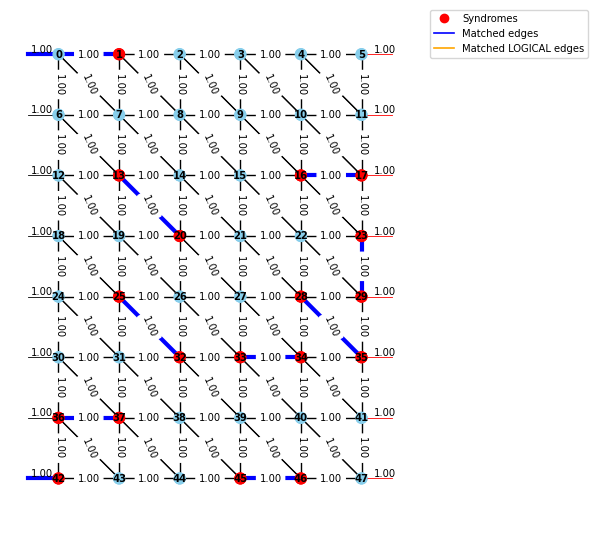

-----INFORMED-----


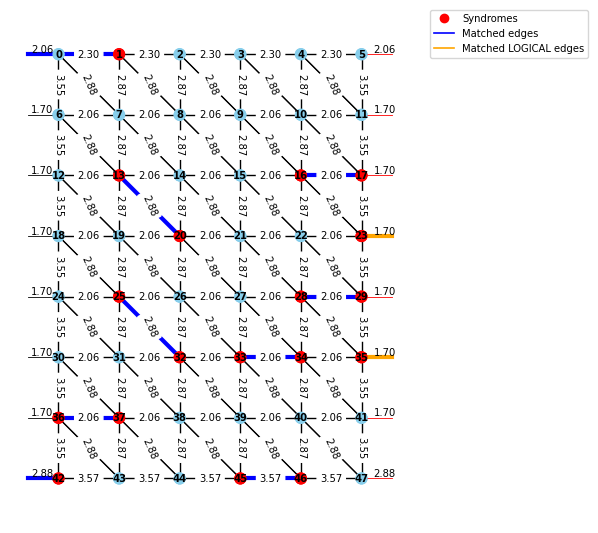

In [ ]:
from soft_info import draw_matching_graph


index = 1

fig_size = (4, 13)
scale_factor = 0.6

to_be_result = result
details = to_be_result.error_details[index]
print("-----IQ-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_flat
details = to_be_result.error_details[index]
print("-----flat-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_informed
details = to_be_result.error_details[index]
print("-----INFORMED-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)


In [ ]:
# print the differences between the two lists using sets
print("diff between IQ and informed:")
print("indices that ")
print(set(result_informed.indices) - set(result.indices))
print(set(result.indices) - set(result_informed.indices))

print()
print("diff between flat and informed:")
print(set(result.indices) - set(result_flat.indices))
print(set(result_flat.indices) - set(result.indices))



diff between IQ and informed:
indices that 
{8192, 8200, 14, 8206, 8207, 17, 8212, 21, 8221, 31, 8224, 34, 38, 41, 8233, 8235, 8237, 48, 49, 50, 8240, 8243, 8244, 8248, 59, 60, 8251, 8252, 8255, 68, 72, 8264, 8267, 76, 8269, 78, 82, 8274, 8276, 8278, 90, 8282, 8283, 8286, 8289, 8291, 100, 8294, 104, 8297, 8298, 107, 8300, 111, 8303, 8305, 8307, 8309, 118, 119, 122, 8315, 125, 8319, 8321, 8322, 8325, 8327, 137, 139, 8333, 8336, 8341, 8342, 152, 8344, 154, 156, 8348, 158, 8352, 163, 8357, 167, 168, 8359, 170, 8362, 8365, 175, 8367, 186, 195, 196, 8393, 202, 205, 206, 207, 8397, 8399, 211, 213, 216, 8408, 218, 219, 221, 222, 8415, 8416, 227, 228, 229, 230, 8424, 237, 238, 8429, 240, 242, 243, 8434, 8440, 249, 8441, 251, 8444, 254, 8449, 8452, 8453, 8455, 264, 8459, 268, 269, 270, 8464, 273, 8466, 275, 280, 281, 8473, 283, 284, 8474, 286, 8478, 288, 289, 8483, 292, 293, 8485, 295, 297, 298, 300, 8492, 8493, 303, 304, 307, 308, 8499, 310, 8505, 8508, 317, 8509, 8513, 322, 8517, 326, 8518, 8